# Model inversion : static biais + RL models

Question : under very low amounts of evidence, how do human sample a complex action space ? Can we infer some form of structure in this exploration ? Can Active Inference provide some answers regarding the mechanistic processes behind it ?



First, we grab the data corresponding to the experiment we're interested in (here, experiment 002). We also remove the subjects that either had technical issues or had very suspicious results. *(we should provide a clear rule on subject exclusion here, maybe based on action variance across all dimensions or reaction times ?).*

In [1]:
# Import the needed packages 
# 
# 1/ the usual suspects
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import plotly as pltly
import plotly.express as px
import plotly.graph_objects as go

import jax
import jax.numpy as jnp
from jax import vmap
from jax.tree_util import tree_map
import jax.random as jr
import tensorflow_probability.substrates.jax.distributions as tfd 

# 2/ Useful functions from our package :
from actynf.jaxtynf.jax_toolbox import _normalize,_jaxlog
from actynf.jaxtynf.jax_toolbox import random_split_like_tree

# The methods to predict actions, compute the log-likelihoods and fit the models :
from simulate.compute_likelihood_full_actions import compute_predicted_actions,compute_loglikelihood
from simulate.compute_likelihood_full_actions import fit_mle_agent,fit_map_agent
from functools import partial

# The simulated environment :
from simulate.hmm_weights import behavioural_process # The environment is statically defined by its HMM matrices
from simulate.generate_observations_full_actions import TrainingEnvironment,run_loop,generate_synthetic_data

# + local functions : 
from database_handling.database_extract import get_all_subject_data_from_internal_task_id
from utils import remove_by_indices
from analysis_tools.preprocess import get_preprocessed_data_from_df
# To make nice plots : 
from simulate.plot_trajectory import plot_training

# The artificial agents : 
from agents_no_ck import lat_assymetric_QL_agent_with_biais as labql_agent  # latent-assymetric-biaised-qlearning agent


c:\Users\annic\OneDrive\Bureau\MainPhD\code\behavioural_exp_code\exploit_results_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Except subjects for predictors :
problematic_subjects_misc = ["611d60c383f4f70ff4bc99fd", # S2 : Did the task twice 
                             "66a74bdfdcaccdc0703894d5", # Subjects with consent revoked 
                            "667d92f2ea5c1542f417285d",
                            "6548f570022275786186ffbd"]

# Import the data from the remote mongodb database & the imported prolific demographics :
INTERNAL_TASK_ID = "003"

# Study 2 : the std of the was 0.025,0.1 and 0.175
PROLIFIC_STUDY_IDs = ["6703ab18d345eaa4893587e0","66f9aee8210357265a5958fc","6703ab1a7ea30557549dc6da"]

TASK_RESULTS_ALL = []
for prolific_study_id in PROLIFIC_STUDY_IDs:
    task_results = get_all_subject_data_from_internal_task_id(INTERNAL_TASK_ID,prolific_study_id,
                                                              process_feedback_data_stream=True,override_save=False)
    print(" - Loaded the task results for study {} \n    ({} subjects.)".format(prolific_study_id,len(task_results)))
    TASK_RESULTS_ALL += task_results
print("Total : {} subjects".format(len(TASK_RESULTS_ALL)))

# Each subject in task results has the following entries : 
# TASK_RESULT_FEATURES, TASK_RESULTS_EVENTS, TASK_RESULTS_DATA, TASK_RESULTS,RT_FB
remove_these_subjects = []
for index,entry in enumerate(TASK_RESULTS_ALL):
    subj_dict,_,_,_ = entry
    subj_name = subj_dict["subject_id"]
    if subj_name in problematic_subjects_misc:
        remove_these_subjects.append(index)

TASK_RESULTS = remove_by_indices(TASK_RESULTS_ALL,remove_these_subjects)
print(str(len(TASK_RESULTS)) + " subjects remaining after removing problematic subjects.")

 - Loaded the task results for study 6703ab18d345eaa4893587e0 
    (49 subjects.)
 - Loaded the task results for study 66f9aee8210357265a5958fc 
    (50 subjects.)
 - Loaded the task results for study 6703ab1a7ea30557549dc6da 
    (50 subjects.)
Total : 149 subjects
145 subjects remaining after removing problematic subjects.


In [3]:
# The initial datframe is the first tuple in our task result list of tuples : 
subjects_df = pd.DataFrame([entry[0] for entry in TASK_RESULTS])

# Avoid too many categories : 
subjects_df['Sex'] = np.where(subjects_df['Sex'].isin(['Male','Female']), subjects_df['Sex'], 'Other')

category_counts = subjects_df['Nationality'].value_counts()
threshold = 2
subjects_df['Nationality_red'] = subjects_df['Nationality'].apply(lambda x: x if category_counts[x] >= threshold else 'Other')

# There was a single noise term for the whole training for each subject : 
subject_noise_parameters = [np.array(entry[2]["parameters"]["noise_int"])[0] for entry in TASK_RESULTS]

# We add it to the df : 
subjects_df["feedback_noise_std"] = subject_noise_parameters

# # Create a pandas dataframe from the list of subject dictionnaries :

# In this dataframe, we're interested in sotring various kinds of data from the trials : 
# 1/ Data from the instruction phase

# 2/ Data from the feedback gauge :
# Timestep values :
all_subject_scores = [subjdata[2]["scoring"] for subjdata in TASK_RESULTS]
subjects_df["raw_feedback_values"] = [subj_scores["feedback"] for subj_scores in all_subject_scores]
# Real time gauge values :
subjects_df["realtime_values"] = [subjdata[3][1] for subjdata in TASK_RESULTS] # Each element is a list of list os arrays (with varying shape)

# 3/ Data from the hidden grid :
# The grid for a specific trial: 
trial_grids = [entry[2]["process"]["grids"] for entry in TASK_RESULTS]
subjects_df["grid_layout"] = trial_grids
# Position value :
subject_positions = [entry[2]["process"]["positions"] for entry in TASK_RESULTS]
subjects_df["subject_positions"] = subject_positions

goal_positions = [np.array(entry[2]["parameters"]["goal_pos"])[:,0,:] for entry in TASK_RESULTS]
subjects_df["goal_position"] = goal_positions

def euclidian_distance(position,goal):
    return jnp.linalg.norm(position-goal,2)
gs = trial_grids[0][0].shape
maximum_euclidian_dist = euclidian_distance(jnp.array(gs) - jnp.ones((2,)),jnp.zeros((2,)))
all_euclidian_distances = vmap(vmap(vmap(euclidian_distance,in_axes=(0,None))))(jnp.array(subject_positions),jnp.array(goal_positions))/maximum_euclidian_dist
subjects_df["norm_distance_to_goal"] = list(all_euclidian_distances)


# 4/ Data from the realized actions :

# Actions performed : this encompasses the points dropped
# But may also include temporal elements such as :
# - the time taken to perform an actions (first point / second point)
# - when the action was performed with regard to the gauge
canvas_size = TASK_RESULTS[0][0]["canvas_size"] # Constant across all subjects + conditions
all_actions_data = np.stack([subjdata[2]["blanket"]["actions"] for subjdata in TASK_RESULTS]).astype(float)

Nsubj,Ntrials,Nactions,Npoints,Nfeatures = all_actions_data.shape
# print(all_actions_data)
# Normalize the point data :
all_actions_data[...,0] = all_actions_data[...,0]/canvas_size[0]
all_actions_data[...,1] = 1.0 - all_actions_data[...,1]/canvas_size[1]


# First, let's get a mask for all actions that were NOT performed :
mask = all_actions_data[...,-1]==1  # values are 1 if the point was recorded
both_points_only = (mask[...,0] & mask[...,1])
     # All points where at least one value is missing

Nactions = all_actions_data[...,0,0].size
Nmissed_actions = (~both_points_only).sum()
print("A total of {}/{} actions were missed. ({:.2f} %)".format(Nmissed_actions,Nactions,100*Nmissed_actions/Nactions))

subjects_df["raw_points"] = list(all_actions_data)


# Encoded barycenters :
barycenter_x = (all_actions_data[...,0,0]+all_actions_data[...,1,0])/2.0
barycenter_y = (all_actions_data[...,0,1]+all_actions_data[...,1,1])/2.0
barycenters = np.stack([barycenter_x,barycenter_y],axis=-1)
subjects_df["action_barycenters"] = list(barycenters)

# Encoded euclidian distance between points :
action_distances = np.linalg.norm(all_actions_data[...,0,:2]-all_actions_data[...,1,:2],axis=-1)
subjects_df["action_distances"] = list(action_distances)

# Encoded evolution of point angles :
angles = np.atan2(all_actions_data[...,1,1]-all_actions_data[...,0,1],all_actions_data[...,1,0]-all_actions_data[...,0,0])
subjects_df["action_angles"] = list(angles)

# Encoded delays between stimuli, point1 and point2 :
all_action_delays = all_actions_data[...,-1,2]
unfit_actions = (all_action_delays<10)
subjects_df["action_time_between_points"] = np.where(all_action_delays>10, all_action_delays, np.nan).tolist()

# Performance metric : we use the average distance to goal state across the lask k_T trials and the last k_t timesteps : (ignoring the blind trial)
last_k_trials,last_t_timesteps = 3,5
all_distances_to_goal = np.mean(np.stack(subjects_df["norm_distance_to_goal"])[:,-last_k_trials:-1,-last_t_timesteps:],axis=(-1,-2))
subjects_df["final_performance"] = (1.0 - all_distances_to_goal).tolist()


# And for the blind trial :
blind_trial_distances_to_goal = np.mean(np.stack(subjects_df["norm_distance_to_goal"])[:,-1,-last_t_timesteps:],axis=(-1))
subjects_df["blind_trial_performance"] = (1.0 - blind_trial_distances_to_goal).tolist()

A total of 33/15950 actions were missed. (0.21 %)


In [4]:
# Variables for the tables / models manipulated here ! 
N_FEEDBACK_OUTCOMES = 10
NTRIALS = 10
T = 11

# MODEL CONSTANTS :
N_LATENT_STATES = 5
MODEL_CONSTANTS = {
    "angle" : {
        "N_actions" : 9, # 8 if we don't filter out close-point angles
        "N_outcomes" : N_FEEDBACK_OUTCOMES,
        "N_states" : N_LATENT_STATES
    },
    "distance" : {
        "N_actions" : 4,
        "N_outcomes" : N_FEEDBACK_OUTCOMES,
        "N_states" : N_LATENT_STATES
    },
    "position" : {
        "N_actions" : 9,
        "N_outcomes" : N_FEEDBACK_OUTCOMES,
        "N_states" : N_LATENT_STATES
    }
}




# If the points were too close, no angle was recorded :
# The limit was arbitrrarily chosen at 7.5 :
min_dist_norm = 7.5/(np.sqrt(2)*750)

preprocessing_options = {
    "actions":{
        "distance_bins" : np.array([0.0,min_dist_norm,0.2,0.5,jnp.sqrt(2) + 1e-10]),
        "angle_N_bins"  : 8,
        "position_N_bins_per_dim" : 3
    },
    "observations":{
        "N_bins" : N_FEEDBACK_OUTCOMES,
        "observation_ends_at_point" : 2
    }
}
    # We can modify these at will
from analysis_tools.preprocess import get_preprocessed_data_from_df

data = get_preprocessed_data_from_df(subjects_df,
                            preprocessing_options,
                            verbose=True,
                            autosave=True,autoload=True,override_save=True,
                            label="default",
                            filter_angles_if_small_distance = True)

Out of the 15950.0 actions performed by our subjects, 15917.0 were 'valid' (99.8 %)
Out of the 15950.0 feedback sequences potentially observed by our subjects, 15950 were 'valid' (100.0 %)


In [5]:
print(data["observations"]["vect"][0].shape)

(145, 10, 11, 10)


In [6]:
# Distance actions
action_dim = "angle"

formatted_stimuli= [data["observations"]["vect"][1]]
bool_stimuli = [jnp.ones_like(stim[...,0]) for stim in formatted_stimuli] # Everything was seen :)
rewards = jnp.array(data["observations"]["deltas"])

actions = {}
for action_dim in ["position","distance","angle"]:
    actions[action_dim] = jnp.array(data["actions"]["vect"][action_dim])[:,:-1,:,:] # Ignore the last trial

Nsubj,Ntrials,Nactions,_ = actions[action_dim].shape
timesteps = jnp.broadcast_to(jnp.arange(Nactions+1),(Nsubj,Ntrials,Nactions+1))

data_all_subjects = (formatted_stimuli,bool_stimuli,rewards,actions,timesteps)



formatted_stimuli,_,_,_,_ = data_all_subjects
Nsubj,Ntrials,Ntimesteps,_ = formatted_stimuli[0].shape
print(Nsubj,Ntrials,Nactions)
print(actions["distance"].shape)

print(timesteps.shape)

145 10 10
(145, 10, 10, 4)
(145, 10, 11)


Let's attempt to explain those results through our behavioural models ! 

Each model uses given priors and initial feature vector range.

In [7]:
from agents_no_ck import random_agent,static_biais_agent_temp,static_biais_agent,rw_agent,assymetric_rw_agent
from agents_no_ck import rw_agent_with_biais,assymetric_rw_agent_with_biais,lat_assymetric_QL_agent_with_biais

zero_one_uni = tfd.Uniform(low=-1e-5,high=1.0+1e-5)  # Bounds may be a bit finnicky and cause loglikelihood overflows
beta_biais_prior = tfd.Normal(10,5)
beta_Q_prior = tfd.Normal(10,5)

# For now, let's assume paarameter ranges and priors are the same across all action dimensions
MODEL_LIBRARY = {
    "random":{
        "model" : partial(random_agent,constants=MODEL_CONSTANTS),
        "ranges" : {"angle":None,"position":None,"distance":None},
        "priors": {"angle":None,"position":None,"distance":None},
        "bypass" : True
    },
    "biais_static":{
        "model" : partial(static_biais_agent,constants=MODEL_CONSTANTS),
        "ranges" : {
            "angle":{
                "biais" : jnp.array([-10,10,9]),
            },
            "position":{
                "biais" : jnp.array([-10,10,9]),
            },
            "distance":{
                "biais" : jnp.array([-10,10,4]),
            }
        },
        "priors" : {
            "angle":{
                "biais" : zero_one_uni
            },
            "position":{
                "biais" : zero_one_uni
            },
            "distance":{
                "biais" : zero_one_uni
            }
        }
    },
    "biais_temp":{
        "model" : partial(static_biais_agent_temp,constants=MODEL_CONSTANTS),
        "ranges" : {
            "angle":{
                "biais" : jnp.array([-10,10,9]),
                "beta_biais" : jnp.array([-3,3])
            },
            "position":{
                "biais" : jnp.array([-10,10,9]),
                "beta_biais" : jnp.array([-3,3])
            },
            "distance":{
                "biais" : jnp.array([-10,10,4]),
                "beta_biais" : jnp.array([-3,3])
            }
        },
        "priors" : {
            "angle":{
                "biais" : zero_one_uni,
                "beta_biais" : beta_biais_prior
            },
            "position":{
                "biais" : zero_one_uni,
                "beta_biais" : beta_biais_prior
            },
            "distance":{
                "biais" : zero_one_uni,
                "beta_biais" : beta_biais_prior
            }
        }
    },
    "rw":{
        "model" : partial(rw_agent,constants=MODEL_CONSTANTS),
        "ranges" : {
            "angle":{
                "alpha_Q" : jnp.array([-10,10]),
                "beta_Q" : jnp.array([-3,3]),
                
            },
            "position":{
                "alpha_Q" : jnp.array([-10,10]),
                "beta_Q" : jnp.array([-3,3])
            },
            "distance":{
                "alpha_Q" : jnp.array([-10,10]),
                "beta_Q" : jnp.array([-3,3]),
            }
        },
        "priors" : {
            "angle":{
                "alpha_Q" : zero_one_uni,
                "beta_Q" : beta_Q_prior
            },
            "position":{
                "alpha_Q" : zero_one_uni,
                "beta_Q" : beta_Q_prior
            },
            "distance":{
                "alpha_Q" : zero_one_uni,
                "beta_Q" : beta_Q_prior
            }
        }
    },
    "rw_assymetric":{
        "model" : partial(assymetric_rw_agent,constants=MODEL_CONSTANTS),
        "ranges" : {
            "angle":{
                "alpha_Q+" : jnp.array([-10,10]),
                "alpha_Q-" : jnp.array([-10,10]),
                "beta_Q" : jnp.array([-3,3]),
                
            },
            "position":{
                "alpha_Q+" : jnp.array([-10,10]),
                "alpha_Q-" : jnp.array([-10,10]),
                "beta_Q" : jnp.array([-3,3])
            },
            "distance":{
                "alpha_Q+" : jnp.array([-10,10]),
                "alpha_Q-" : jnp.array([-10,10]),
                "beta_Q" : jnp.array([-3,3]),
            }
        },
        "priors" : {
            "angle":{
                "alpha_Q+" : zero_one_uni,
                "alpha_Q-" : zero_one_uni,
                "beta_Q" : beta_Q_prior
            },
            "position":{
                "alpha_Q+" : zero_one_uni,
                "alpha_Q-" : zero_one_uni,
                "beta_Q" : beta_Q_prior
            },
            "distance":{
                "alpha_Q+" : zero_one_uni,
                "alpha_Q-" : zero_one_uni,
                "beta_Q" : beta_Q_prior
            }
        }
    },
    "rw_with_biais":{
        "model" : partial(rw_agent_with_biais,constants=MODEL_CONSTANTS),
        "ranges" : {
            "angle":{
                "alpha_Q" : jnp.array([-10,10]),
                "beta_Q" : jnp.array([-3,3]),
                "biais" : jnp.array([-10,10,9]),
                "beta_biais" : jnp.array([-3,3])
            },
            "position":{
                "alpha_Q" : jnp.array([-10,10]),
                "beta_Q" : jnp.array([-3,3]),
                "biais" : jnp.array([-10,10,9]),
                "beta_biais" : jnp.array([-3,3])
            },
            "distance":{
                "alpha_Q" : jnp.array([-10,10]),
                "beta_Q" : jnp.array([-3,3]),
                "biais" : jnp.array([-10,10,4]),
                "beta_biais" : jnp.array([-3,3])
            }
        },
        "priors" : {
            "angle":{
                "alpha_Q" : zero_one_uni,
                "beta_Q" : beta_Q_prior,
                "biais" : zero_one_uni,
                "beta_biais" : beta_biais_prior
            },
            "position":{
                "alpha_Q" : zero_one_uni,
                "beta_Q" : beta_Q_prior,
                "biais" : zero_one_uni,
                "beta_biais" : beta_biais_prior
            },
            "distance":{
                "alpha_Q" : zero_one_uni,
                "beta_Q" : beta_Q_prior,
                "biais" : zero_one_uni,
                "beta_biais" : beta_biais_prior
            }
        }
    },
    "rw_assymetric_with_biais":{
        "model" : partial(assymetric_rw_agent_with_biais,constants=MODEL_CONSTANTS),
        "ranges" : {
            "angle":{
                "alpha_Q+" : jnp.array([-10,10]),
                "alpha_Q-" : jnp.array([-10,10]),
                "beta_Q" : jnp.array([-3,3]),
                "biais" : jnp.array([-10,10,9]),
                "beta_biais" : jnp.array([-3,3])
            },
            "position":{
                "alpha_Q+" : jnp.array([-10,10]),
                "alpha_Q-" : jnp.array([-10,10]),
                "beta_Q" : jnp.array([-3,3]),
                "biais" : jnp.array([-10,10,9]),
                "beta_biais" : jnp.array([-3,3])
            },
            "distance":{
                "alpha_Q+" : jnp.array([-10,10]),
                "alpha_Q-" : jnp.array([-10,10]),
                "beta_Q" : jnp.array([-3,3]),
                "biais" : jnp.array([-10,10,4]),
                "beta_biais" : jnp.array([-3,3])
            }
        },
        "priors" : {
            "angle":{
                "alpha_Q+" : zero_one_uni,
                "alpha_Q-" : zero_one_uni,
                "beta_Q" : beta_Q_prior,
                "biais" : zero_one_uni,
                "beta_biais" : beta_biais_prior
            },
            "position":{
                "alpha_Q+" : zero_one_uni,
                "alpha_Q-" : zero_one_uni,
                "beta_Q" : beta_Q_prior,
                "biais" : zero_one_uni,
                "beta_biais" : beta_biais_prior
            },
            "distance":{
                "alpha_Q+" : zero_one_uni,
                "alpha_Q-" : zero_one_uni,
                "beta_Q" : beta_Q_prior,
                "biais" : zero_one_uni,
                "beta_biais" : beta_biais_prior
            }
        }
    }
}
    
print(MODEL_LIBRARY)

{'random': {'model': functools.partial(<function random_agent at 0x0000024EF0A65AB0>, constants={'angle': {'N_actions': 9, 'N_outcomes': 10, 'N_states': 5}, 'distance': {'N_actions': 4, 'N_outcomes': 10, 'N_states': 5}, 'position': {'N_actions': 9, 'N_outcomes': 10, 'N_states': 5}}), 'ranges': {'angle': None, 'position': None, 'distance': None}, 'priors': {'angle': None, 'position': None, 'distance': None}, 'bypass': True}, 'biais_static': {'model': functools.partial(<function static_biais_agent at 0x0000024EF0A66440>, constants={'angle': {'N_actions': 9, 'N_outcomes': 10, 'N_states': 5}, 'distance': {'N_actions': 4, 'N_outcomes': 10, 'N_states': 5}, 'position': {'N_actions': 9, 'N_outcomes': 10, 'N_states': 5}}), 'ranges': {'angle': {'biais': Array([-10,  10,   9], dtype=int32)}, 'position': {'biais': Array([-10,  10,   9], dtype=int32)}, 'distance': {'biais': Array([-10,  10,   4], dtype=int32)}}, 'priors': {'angle': {'biais': <tfp.distributions.Uniform 'Uniform' batch_shape=[] event

In [12]:
# Let's make it a dedicated method afterwards !
standard_n_heads = 20
standard_n_steps = 500
lr = 5e-2
rngkey = jr.PRNGKey(0)

option_verbose = True

formatted_stimuli,_,_,_,_ = data_all_subjects
Nsubj,Ntrials,Ntimesteps,_ = formatted_stimuli[0].shape



results_dict = {}
for agent_name, agent_contents in MODEL_LIBRARY.items():
    print("     -> Agent : {}".format(agent_name))
    rngkey,local_key = jr.split(rngkey)
    
    agent = agent_contents["model"]
    initial_parameter_range = agent_contents["ranges"]
    agent_priors = agent_contents["priors"]
    
    # Model specific options :
    model_steps = agent_contents["n_steps"] if ("n_steps" in agent_contents) else standard_n_steps
    model_heads = agent_contents["n_heads"] if ("n_heads" in agent_contents) else standard_n_heads
    bypass_fit = agent_contents["bypass"] if ("bypass" in agent_contents) else False
    vectorize_computations = agent_contents["vectorize_fit"] if ("vectorize_fit" in agent_contents) else True
    
        
    # Agent functions
    _,_,_,_,_,encoder = agent(None)
    def fit_agent(_data_one_subject,_fit_rng_key,method = "mle"):  
        if bypass_fit:
            _opt_vectors = jnp.zeros((model_heads,))
            _lls =   vmap(lambda x : compute_loglikelihood(_data_one_subject,agent(encoder(x)),'sum'))(_opt_vectors)
            return None,None,_lls
            
            
        if method.lower() == "mle":
            _opt_vectors,(_,_loss_history,_param_history),_encoding_function = fit_mle_agent(_data_one_subject,agent,
                                                                        initial_parameter_range,
                                                                        _fit_rng_key,
                                                                        true_hyperparams=None,                          
                                                                        num_steps=model_steps,n_heads=model_heads,
                                                                        start_learning_rate=lr,
                                                                        verbose=option_verbose)
        
        elif method.lower() == "map":
            # Multi-iteration based MAP : (we randomize the initial point and try to find minimas)
            _opt_vectors,(_,_loss_history,_param_history),_encoding_function = fit_map_agent(_data_one_subject,agent,
                                                                        initial_parameter_range,agent_priors,
                                                                        _fit_rng_key,
                                                                        true_hyperparams=None,                          
                                                                        num_steps=model_steps,n_heads=model_heads,
                                                                        start_learning_rate=lr,
                                                                        verbose=option_verbose)
        
        else :            
            raise NotImplementedError("Unrecognized fitting method : {}".format(method))
        
        # Regardless of the cost function, let's estimate the log-likelihood of the fitted estimators :
        _lls =   vmap(lambda x : compute_loglikelihood(_data_one_subject,agent(_encoding_function(x)),'sum'))(_opt_vectors)
        return _loss_history,_opt_vectors,_lls
    
    
    
    
    random_keys_all_subj = jr.split(local_key,num = Nsubj)
    fit_one_subject = partial(fit_agent,_fit_rng_key=local_key)
    
    if vectorize_computations : # Better, as long as we don't run into memory issues
        
        loss_histories,best_params,lls = vmap(fit_one_subject)(data_all_subjects)
        
        fit_results = {
            "losses_hist" : loss_histories,
            "params" : best_params,
            "logliks" : lls,
            "encoder" : encoder
        }
    else : 
        clean_this = []
        for subj in range(Nsubj):
            print("Subject {}/{}".format(subj,Nsubj))
            subj_key = random_keys_all_subj[subj]
            
            # Extract the subj-th element of each array :
            (formatted_stimuli,bool_stimuli,rewards,actions,timesteps) = data_all_subjects
            
            # print(formatted_stimuli[0].shape)
            # print(bool_stimuli)
            data_this_subject = (formatted_stimuli[0][subj],bool_stimuli[0][subj],rewards[subj],
                                 {dim : table[subj] for dim,table in actions.items()},timesteps[subj])
            # first_values = tuple(arr[subj] for arr in data_all_subjects)

            # print(data_this_subject)

            
            loss_hist, opt_vec, lls = fit_agent(data_this_subject,subj_key)
            clean_this.append({
                "losses_hist" : loss_hist,
                "params" : opt_vec,
                "logliks" : lls,
                "encoder" : encoder
            })
            
        # Clean the list here
        
        fit_results = clean_this
    
    results_dict[agent_name] = fit_results
           

     -> Agent : random
     -> Agent : biais_static
step 0, loss: Traced<ShapedArray(float32[])>with<BatchTrace(level=2/0)> with
  val = Traced<ShapedArray(float32[20])>with<BatchTrace(level=1/0)> with
    val = Array([[564.04706, 614.0711 , 548.1371 , ..., 628.8309 , 528.6795 ,
        552.95233],
       [598.86505, 541.1576 , 605.6386 , ..., 542.10895, 603.77527,
        619.0957 ],
       [586.2843 , 577.7992 , 552.5825 , ..., 579.5054 , 583.5788 ,
        598.8881 ],
       ...,
       [597.95276, 582.0994 , 516.59656, ..., 601.08905, 601.5331 ,
        621.3614 ],
       [580.15576, 595.6905 , 588.0607 , ..., 629.6542 , 623.65436,
        607.344  ],
       [563.0646 , 615.85706, 544.4129 , ..., 618.30286, 554.0781 ,
        556.4886 ]], dtype=float32)
    batch_dim = 0
  batch_dim = 0
step 10, loss: Traced<ShapedArray(float32[])>with<BatchTrace(level=2/0)> with
  val = Traced<ShapedArray(float32[20])>with<BatchTrace(level=1/0)> with
    val = Array([[528.9866 , 589.46204, 544.355

In [13]:
print(results_dict["random"])

{'losses_hist': None, 'params': None, 'logliks': ({'angle': Array([[-219.72247, -219.72247, -219.72247, ..., -219.72247, -219.72247,
        -219.72247],
       [-219.72247, -219.72247, -219.72247, ..., -219.72247, -219.72247,
        -219.72247],
       [-219.72247, -219.72247, -219.72247, ..., -219.72247, -219.72247,
        -219.72247],
       ...,
       [-219.72247, -219.72247, -219.72247, ..., -219.72247, -219.72247,
        -219.72247],
       [-219.72247, -219.72247, -219.72247, ..., -219.72247, -219.72247,
        -219.72247],
       [-219.72247, -219.72247, -219.72247, ..., -219.72247, -219.72247,
        -219.72247]], dtype=float32), 'distance': Array([[-138.62941, -138.62941, -138.62941, ..., -138.62941, -138.62941,
        -138.62941],
       [-138.62941, -138.62941, -138.62941, ..., -138.62941, -138.62941,
        -138.62941],
       [-138.62941, -138.62941, -138.62941, ..., -138.62941, -138.62941,
        -138.62941],
       ...,
       [-138.62941, -138.62941, -138.6294

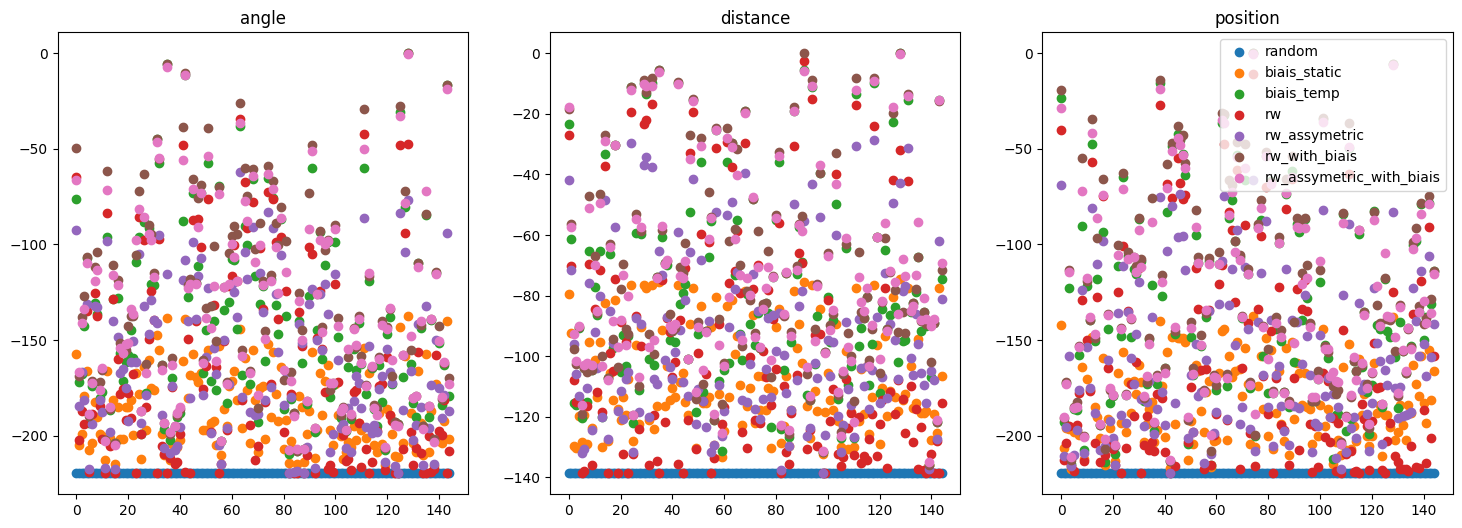

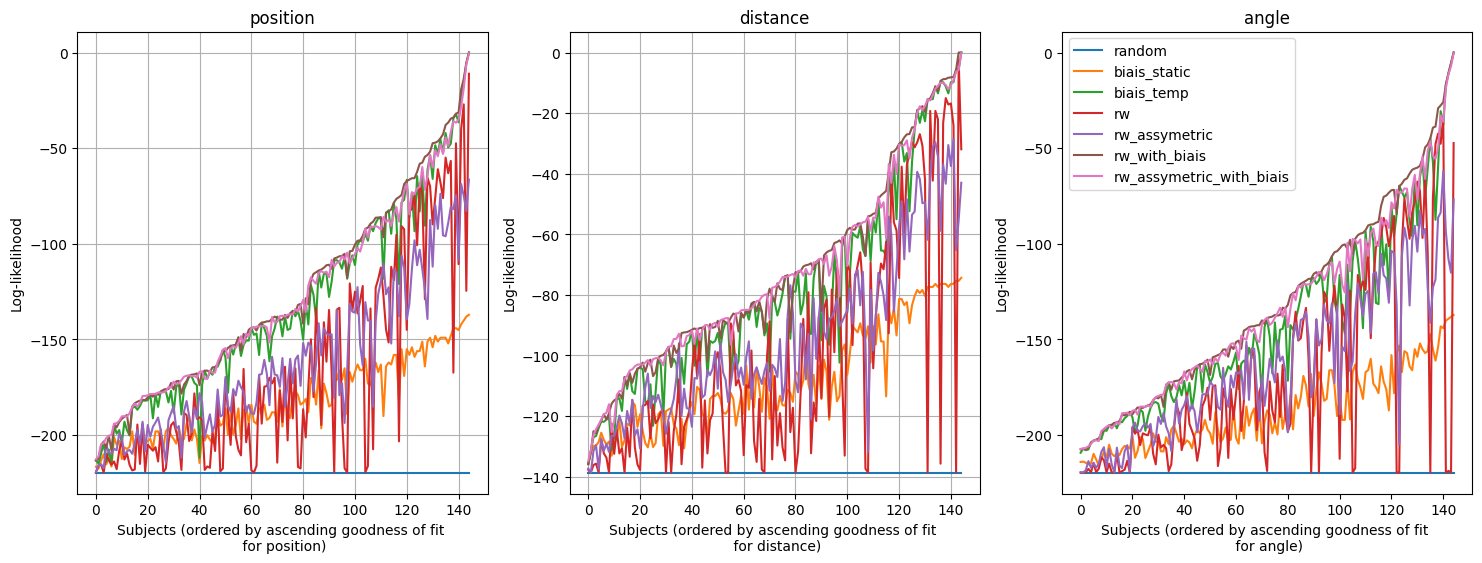

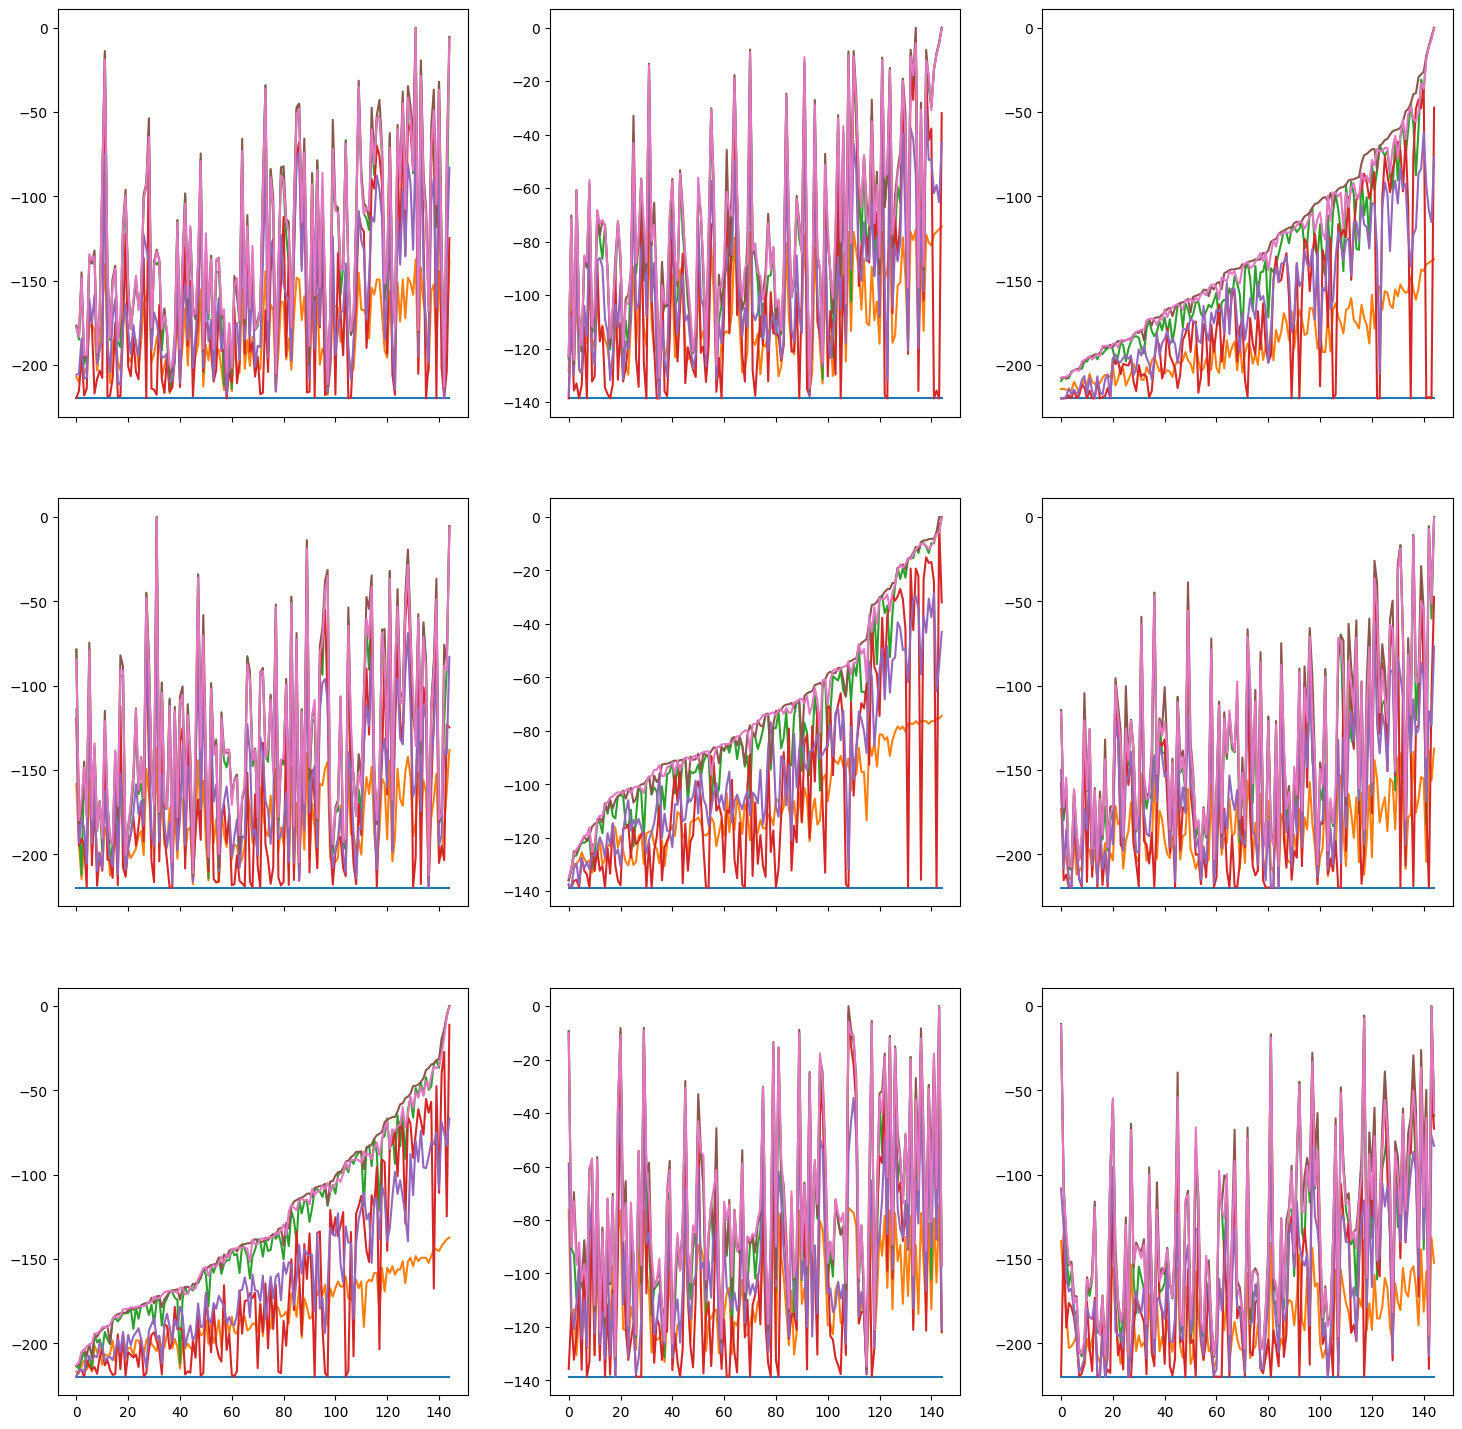

In [14]:
fig,axs = plt.subplots(1,3,figsize=(6*3,6))
for model,results in results_dict.items():
    lls,ces = results["logliks"]
    
    for k,action_mod in enumerate(lls.keys()):        
        best_fits = (jnp.max(lls[action_mod],axis=-1))
        
        Nsubj = best_fits.shape[0]
        axs[k].scatter(np.arange(Nsubj),best_fits,label = model)
        axs[k].set_title(action_mod)
axs[-1].legend()

# Same figure with the most likely first :
fig,axs = plt.subplots(1,3,figsize=(6*3,6),sharex=True)
for k,action_mod in enumerate(["position","distance","angle"]):
    ax = axs[k] 
    
    model_fit_table = np.stack([np.max(r['logliks'][0][action_mod],-1) for r in results_dict.values()])
    indices = np.argsort(np.max(model_fit_table,0))
    ordered_table = (model_fit_table[:,indices])
        
    for i,(model,results) in enumerate(results_dict.items()):
        lls,ces = results["logliks"]
        
        # model_fit_table = np.stack([np.max(lls["logliks"],-1) for r in results_dict.values()])
        
        ax.plot(np.arange(Nsubj),ordered_table[i,:],label = model)

    ax.set_ylabel("Log-likelihood")
    ax.set_xlabel("Subjects (ordered by ascending goodness of fit \n for {})".format(action_mod))
    ax.set_title(action_mod)
    ax.grid()
ax.legend()

fig,axs = plt.subplots(3,3,figsize=(6*3,6*3),sharex=True)
for kk,comparison_mod in enumerate(results_dict["random"]['logliks'][0].keys()):
    
    # Same figure with the most likely first (only looking at angle predictability):
    model_fit_table = np.stack([np.max(r['logliks'][0][comparison_mod],-1) for r in results_dict.values()])
    indices = np.argsort(np.max(model_fit_table,0))
        
    
    for k,action_mod in enumerate(["position","distance","angle"]):
        axline = axs[kk] 
        
        model_fit_table = np.stack([np.max(r['logliks'][0][action_mod],-1) for r in results_dict.values()])
        ordered_table = (model_fit_table[:,indices])
        
        for i,(model,results) in enumerate(results_dict.items()):
            lls,ces = results["logliks"]
            
            # model_fit_table = np.stack([np.max(lls["logliks"],-1) for r in results_dict.values()])
            
            axline[k].plot(np.arange(Nsubj),ordered_table[i,:],label = model)

        ax.set_ylabel("Log-likelihood")
        ax.set_xlabel("Subjects (ordered by ascending goodness of fit \n for angle)")
        ax.set_title(action_mod)
        ax.legend()
        ax.grid()

There is only a light correlation between our model ability to predict subject angles and the other dimensions, hinting at rather independent action modality representation in subjects !

So, when we're looking at all action dimensions simultaneously, we can (kind of) predict some subjects using our very basic models. Are there actually any subjects that we can't predict better than a random model ?

[  5  25  82  98  15 104 106   9   6  49 116 110  99 105  19  33  13 108
  85  40 120 123  17  58  27   2 141  83 117  11 114 102  56  50 138 133
 140  70  86  20 126  34 130 134  75  39  93  44 113 124   3  72   7  88
  95  21 144  37 132 129   4  10  59 112  69  53  22  78  96 136  67  23
 107 119  84  60  73 115  64 137  36  28 100   1 122  92  80 109 121  52
 139  77 142  90  54 127 135  55  66  76  16  26  97   8  89 103  79  81
  65  18  71  43  46  31  14  47  51  61  57  41  45  12 101  62  68  87
 125  63  48 131   0  24  30 143  29  94  38 111  32 118  42  35  91  74
 128]


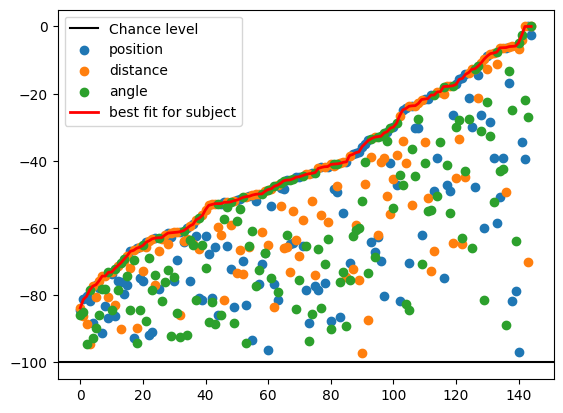

In [15]:

dimensions=  ["position","distance","angle"]

all_lls = np.stack([[r['logliks'][0][act_mod]  for act_mod in ["position","distance","angle"]]for r in results_dict.values()])


best_lls_per_subj = np.max(all_lls,axis=(-1))


# Let's compare the predictability of each modality by normalizing it by the number of categories : 
best_lls_per_subj[:,0,:] = best_lls_per_subj[:,0,:]/np.log(9.0)
best_lls_per_subj[:,1,:] = best_lls_per_subj[:,1,:]/np.log(4.0)
best_lls_per_subj[:,2,:] = best_lls_per_subj[:,2,:]/np.log(9.0)


# print(best_lls_per_subj.shape)

best_model = np.max(best_lls_per_subj,axis=0)

best_overall = np.max(best_model,axis=0)
indices = np.argsort(best_overall)

print(indices)
plt.axhline(100*np.log(1/9.0)/np.log(9.0),color="black",label="Chance level")
for modality in range(3):
    plt.scatter(np.arange(indices.shape[0]),best_model[modality,indices],label=dimensions[modality])
plt.plot(np.arange(indices.shape[0]),best_overall[indices],color="red",linewidth=2,label = "best fit for subject")
plt.legend()
plt.show()



Nice, no behaviour is completely unpredictable ! Maybe we just don't observe the correct dimension ! 

More generally, some behaviours are better explained by our models than others, hinting that there probably are alternative decision making processes at play here OR that there is a significant amount of randomness into our participant behaviour. 

It's important to remain open about results and assume that some unseen process has caused the behaviour (or that other decision making algorithm would better match a changing context). Of course, we can also assume that the subjects acted very randomly because of a lack of understanding / motivation but this kind of behaviour is generally explained better by very biaised behaviour :) 

(10, 10)


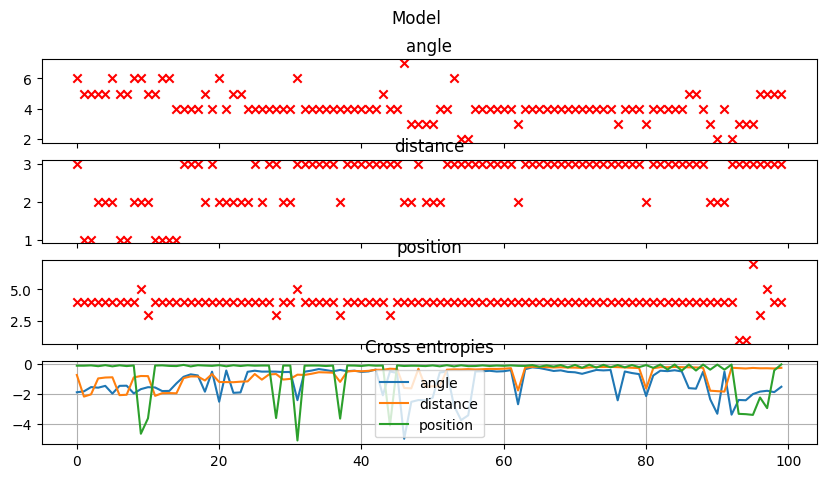

In [16]:
subject_id = 43

# Let's plot some cross entropies to check the difference between our reconstruction and the actual plots !
lls,ces = results["logliks"]



# Let's grab the most likely result index : 
subject_best_index = {key:np.argmax(table[subject_id]) for key,table in lls.items()}
subject_ces = {key:table[subject_id,subject_best_index[key]] for key,table in ces.items()}

# Extract the subj-th element of each array :
(formatted_stimuli,bool_stimuli,rewards,actions,timesteps) = data_all_subjects
data_this_subject = (formatted_stimuli[0][subject_id],bool_stimuli[0][subject_id],rewards[subject_id],
                        {dim : table[subject_id] for dim,table in actions.items()},timesteps[subject_id])

_,_,rwrds,true_actions,_ = data_this_subject
n_trials,n_steps,_ = (true_actions["angle"].shape)

fig,axs = plt.subplots(len(true_actions)+1,1,figsize=(n_trials,5),sharex=True)
fig.suptitle("Model")

for i,key in enumerate(subject_ces.keys()):
    ax = axs[i]

    N_action_cat = true_actions[key].shape[-1]
    
    # prediction_map = np.reshape(predicted_actions[key],(-1,N_action_cat))
    ax.set_title(key)    
    # ax.imshow(prediction_map.T)
        
    # N_timesteps  = prediction_map.shape[0]
    ax.scatter(np.arange(n_trials*n_steps),np.argmax(true_actions[key],axis=-1),color="red",marker="x")

print(subject_ces["angle"].shape)

ax = axs[-1]
ax.set_title("Cross entropies")
# for head in range(subject_ces["angle"].shape[0]):
for mod,series in subject_ces.items():
    ax.plot(series.flatten(),label=mod)
ax.legend()
ax.grid()

Let's focus on the rw agent with biais for now, as it seems to be the most consensual model for all subjects :

0.0039887684
0.15343045
1.8665378e-06
4.3854793e-06
9.2586706e-05
2.3595595e-07
0.5537439
0.97705865
0.99577844
0.033608675
0.00017113832
0.88513005
1.0
0.9987839
0.9966791
6.3951364e-07
0.00024099687
0.343311
0.017316373
0.99905056
0.08277299
0.23205405
0.476973
1.0
0.04293289
0.9944915
0.57343733
0.46828312
0.47215036
0.4665571
0.57342863
0.46522772
0.1450452
0.46721965
0.57194304
0.54458725
0.24085294
0.46816882
0.48950753
0.5671805
0.22907774
0.0029107179
0.4848392
0.526015
0.40702528
0.006050926
0.6189938
0.5368155
0.88129926
0.5508974
0.99420327
0.52474034
0.5774413
0.9948406
0.99388474
0.5248044
0.09597003
1.0
0.5224554
0.7347257
0.00019126484
1.5893283e-05
0.35902047
0.00016133417
9.954569e-06
2.6160846e-05
0.4080171
9.9358695e-05
0.00013134601
0.97590387
0.0003703133
0.00036849827
1.0
0.00058401754
0.31138027
0.02400997
5.1131665e-11
7.538424e-05
2.40377e-05
5.8493806e-05
0.00026965872
0.8942152
3.5522282e-06
0.9319744
5.6195645e-06
0.9363791
0.93642193
0.992604
0.95783895
0.1

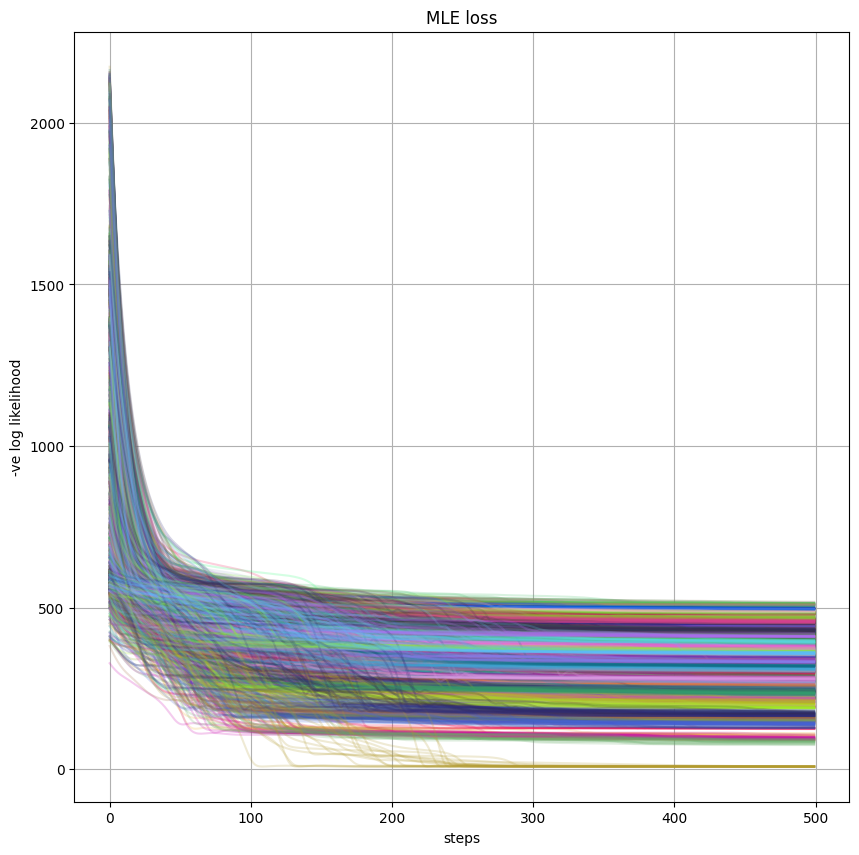

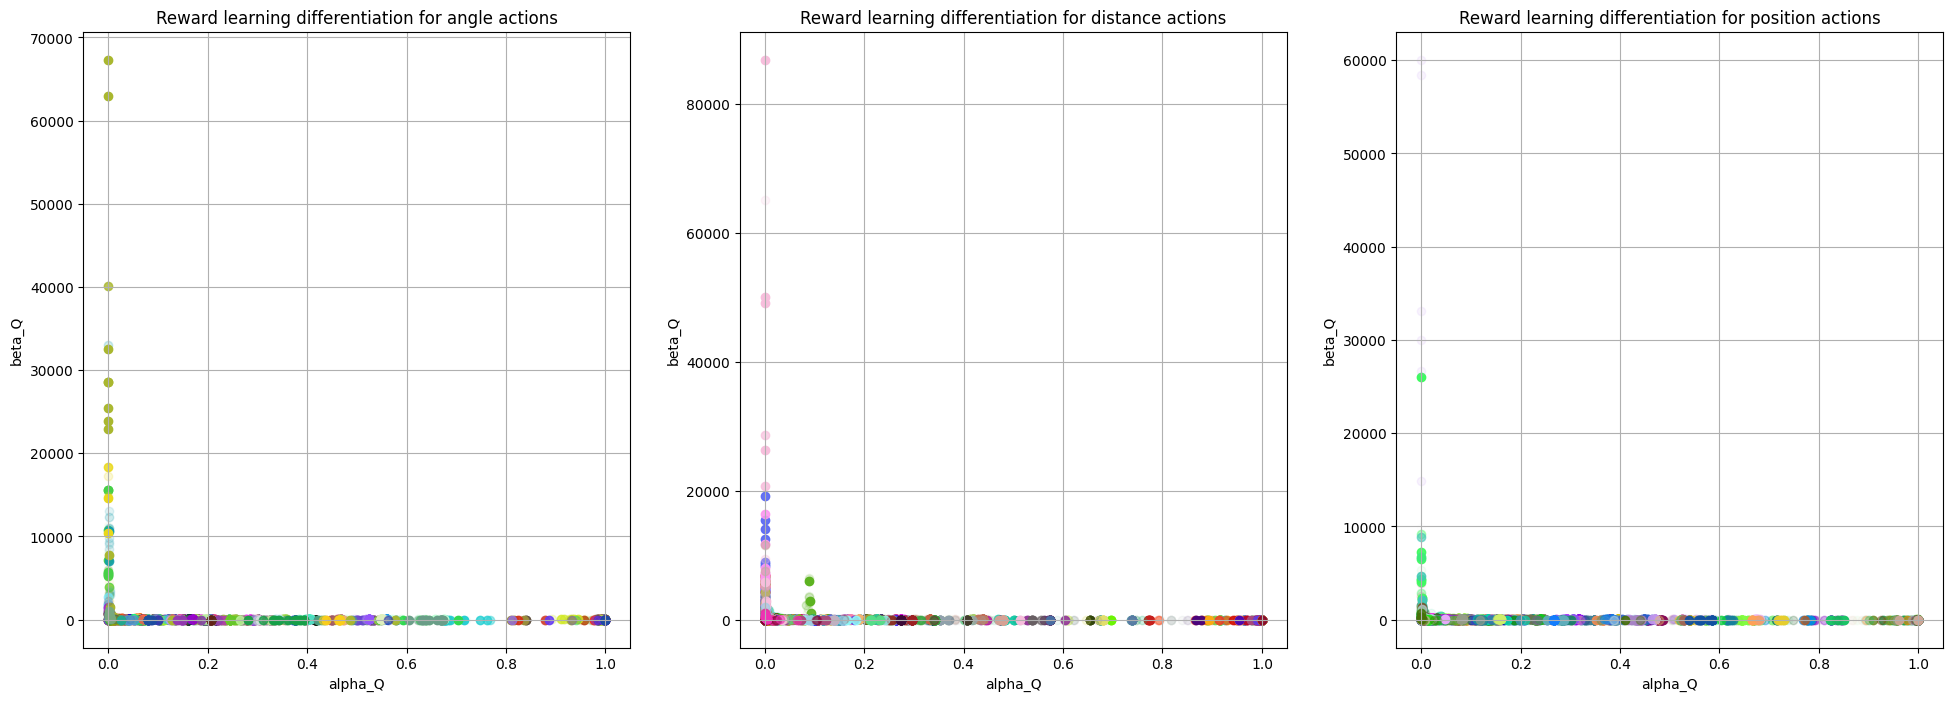

In [18]:


interesting_model = results_dict["rw_with_biais"]

losses = interesting_model["losses_hist"]
N_subj,N_heads,N_steps = losses.shape

# Losses plot
fig,ax = plt.subplots(figsize = (10,10))
ax.set_title("MLE loss")
for s in range(N_subj):
    color = np.random.random((3,))
    for h in range(N_heads):
        ax.plot(losses[s,h],color=color,alpha = 0.2)
ax.set_xlabel("steps")
ax.set_ylabel("-ve log likelihood")
ax.grid()

# Parameters : 
winning_parameter_vectors = interesting_model["params"]

model_encoder = interesting_model["encoder"]

encoded_params = vmap(vmap(lambda x : model_encoder(x)))(winning_parameter_vectors)

# We rate these parameters given the loglikelihood of their inversion : 
lls,ces = interesting_model["logliks"]


def likelihood_filter(x,inversion_head_selection_temperature = 1.0):
    filter_out_low_likelihoods =  jax.nn.softmax(inversion_head_selection_temperature*x,axis=-1)
    head_filters = filter_out_low_likelihoods/jnp.max(filter_out_low_likelihoods,axis=-1,keepdims=True)
    return head_filters

filter_heads = tree_map(likelihood_filter,lls)

# Plot the resulting parameters : 
fig,axs = plt.subplots(1,3,figsize = (3*8,8))
for k,mod in enumerate(encoded_params.keys()):
    ax = axs[k]
    
    plot_this = encoded_params[mod]
    
    ax.set_title("Reward learning differentiation for {} actions".format(mod))
    for s in range(N_subj):
        color = np.random.random((3,))
        for h in range(N_heads):
            print(np.array(filter_heads[mod][s,h]))
            ax.scatter(np.array(plot_this["alpha_Q"][s,h]),np.array(plot_this["beta_Q"][s,h]),alpha = float(filter_heads[mod][s,h]),color=color)
    ax.set_xlabel("alpha_Q")
    ax.set_ylabel("beta_Q")
    ax.grid()



# plot_df = pd.DataFrame()
# plot_df["final_perf"] = list(np.array(subjects_df["final_performance"]))
# plot_df["noise_std"] = subjects_df["feedback_noise_std"]
# plot_df["rw_ck_alpha"] = np.reshape(alpha,(Nsubj,-1)).tolist()
# plot_df["rw_ck_beta"] = np.reshape(beta,(Nsubj,-1)).tolist()
# plot_df["rw_ck_alpha_ck"] = np.reshape(alpha_ck,(Nsubj,-1)).tolist()
# plot_df["rw_ck_beta_ck"] = np.reshape(beta_ck,(Nsubj,-1)).tolist()
# plot_df["rw_ck_logliks"] = list(np.array(model_fit_table))

# filter_out_low_likelihoods =  jax.nn.softmax(5.0*model_fit_table,axis=-1)
# head_filters = filter_out_low_likelihoods/jnp.max(filter_out_low_likelihoods,axis=-1,keepdims=True)
# head_filters = np.array(head_filters)
# plot_df["rw_ck_logliks_alpha"] = list(head_filters)

# df_exploded = plot_df.apply(pd.Series.explode)
# print(df_exploded.dtypes)
# fig,axes=  plt.subplots(1,2,figsize=(10,5))
# fig.suptitle("Weights of the winning model grouped by")
# axes[0].set_title("Performance")
# sns.scatterplot(ax=axes[0],data= df_exploded,x="rw_ck_alpha",y="rw_ck_beta",hue="final_perf")
# axes[1].set_title("Feedback noise")
# sns.scatterplot(ax=axes[1],data = df_exploded,x="rw_ck_alpha",y="rw_ck_beta",hue="noise_std")
# plt.show()

# fig,axes=  plt.subplots(1,2,figsize=(10,5))
# sns.scatterplot(ax=axes[0],data= df_exploded,x="rw_ck_alpha_ck",y="rw_ck_beta_ck",hue="final_perf")
# sns.scatterplot(ax=axes[1],data = df_exploded,x="rw_ck_alpha_ck",y="rw_ck_beta_ck",hue="noise_std")
# plt.show()

# sns.scatterplot(data=df_exploded,x="rw_ck_logliks",y="final_perf",hue="noise_std")
# plt.show()

Ok, that's cool I guess but does that relate to subject performance or experimental conditions ?

In [19]:
print(ces["angle"].shape)

ll_per_mod = tree_map(lambda x : jnp.sum(x,axis=(-1,-2)),ces)
print(ll_per_mod["angle"].shape)

(145, 20, 10, 10)
(145, 20)


final_perf    float64
noise_std     float64
alpha_q        object
beta_q         object
logliks        object
dtype: object
final_perf    float64
noise_std     float64
alpha_q        object
beta_q         object
logliks        object
dtype: object
final_perf    float64
noise_std     float64
alpha_q        object
beta_q         object
logliks        object
dtype: object


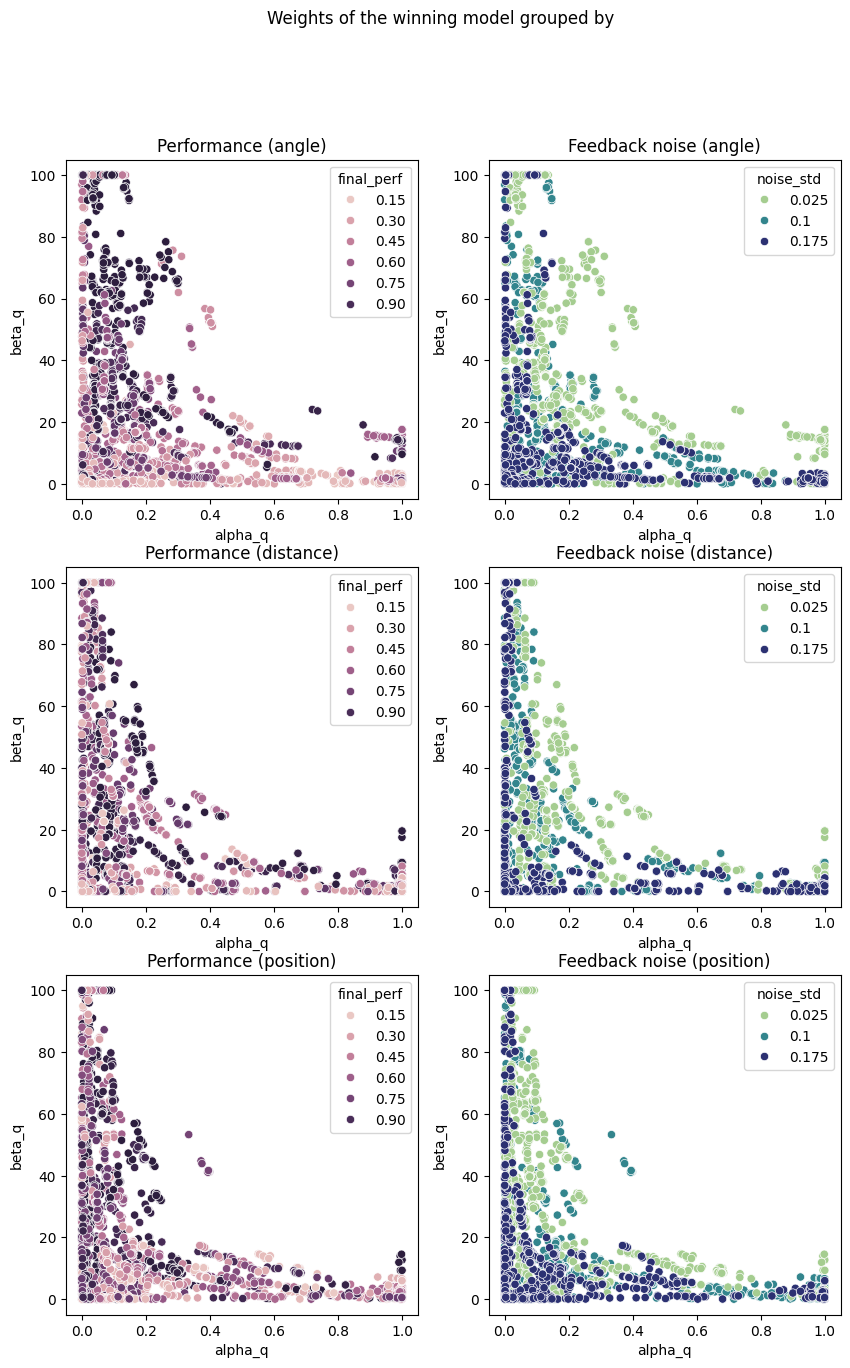

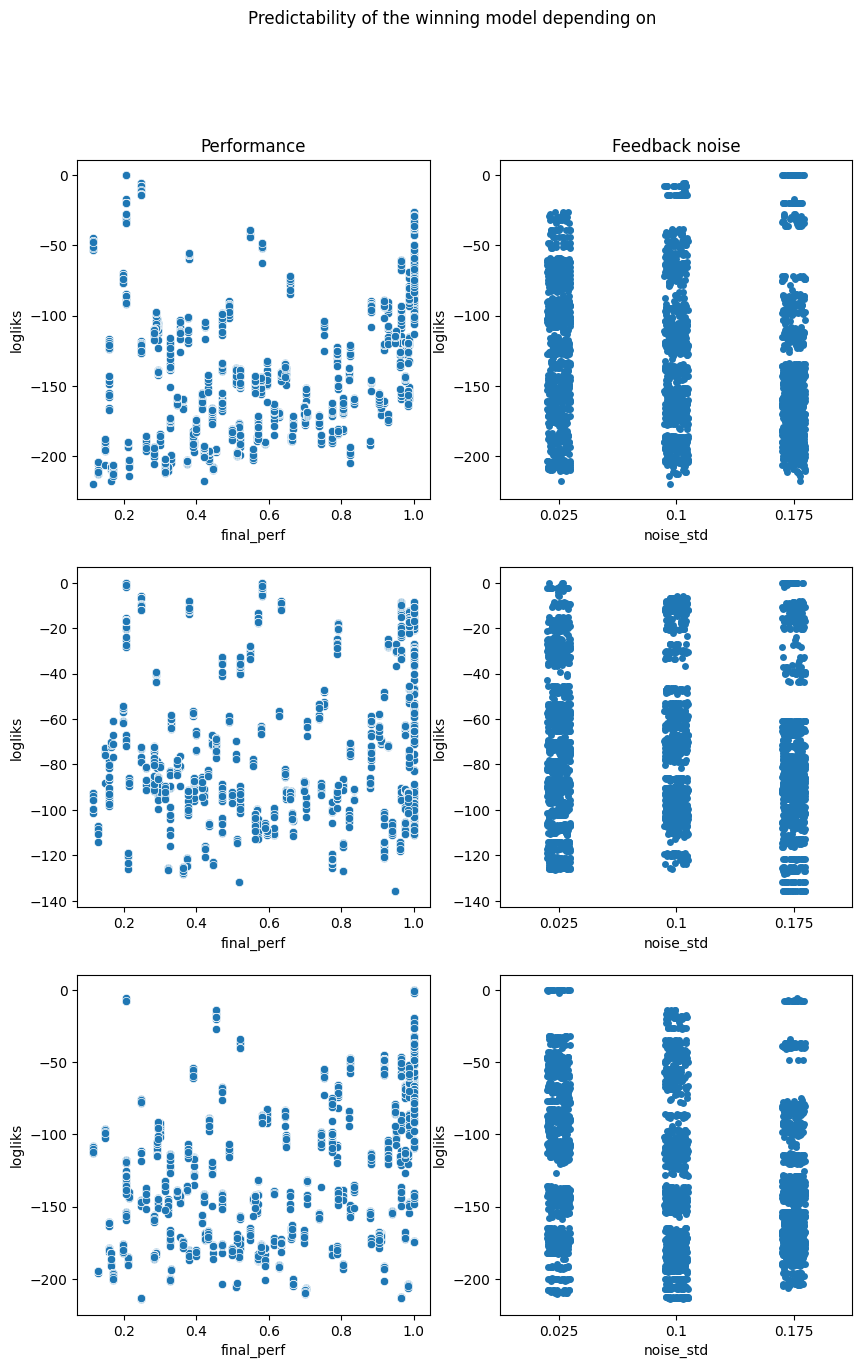

In [21]:

fig,axes=  plt.subplots(3,2,figsize=(10,15))
fig.suptitle("Weights of the winning model grouped by")
axes[0,0].set_title("Performance")
axes[0,1].set_title("Feedback noise")

fig2,axes2=  plt.subplots(3,2,figsize=(10,15))
fig2.suptitle("Predictability of the winning model depending on")
axes2[0,0].set_title("Performance")
axes2[0,1].set_title("Feedback noise")

for k,mod in enumerate(encoded_params.keys()):
    axes[k,0].set_title("Performance ({})".format(mod))
    axes[k,1].set_title("Feedback noise ({})".format(mod))
    
    
    plot_df = pd.DataFrame()
    plot_df["final_perf"] = list(np.array(subjects_df["final_performance"]))
    plot_df["noise_std"] = subjects_df["feedback_noise_std"]
    
    my_params= encoded_params[mod]
    my_lls = ll_per_mod[mod]
    
    plot_df["alpha_q"] = np.reshape(my_params["alpha_Q"],(Nsubj,-1)).tolist()
    plot_df["beta_q"] = np.clip(np.reshape(my_params["beta_Q"],(Nsubj,-1)),0,100.0).tolist()
    plot_df["logliks"] = np.reshape(my_lls,(Nsubj,-1)).tolist()

    df_exploded = plot_df.apply(pd.Series.explode)
    print(df_exploded.dtypes)
    
    
    
    sns.scatterplot(ax=axes[k,0],data= df_exploded,x="alpha_q",y="beta_q",hue="final_perf")
    sns.scatterplot(ax=axes[k,1],data = df_exploded,x="alpha_q",y="beta_q",hue="noise_std",palette=sns.color_palette("crest", as_cmap=True))
    
    sns.scatterplot(ax=axes2[k,0],data=df_exploded,x="final_perf",y="logliks")
    sns.stripplot(ax=axes2[k,1],data=df_exploded,x="noise_std",y="logliks",dodge=True)
    
plt.show()

    
    # sns.scatterplot(ax=axes[0],data= df_exploded,x="rw_ck_alpha_ck",y="rw_ck_beta_ck",hue="final_perf")
    # sns.scatterplot(ax=axes[1],data = df_exploded,x="rw_ck_alpha_ck",y="rw_ck_beta_ck",hue="noise_std")
    # plt.show()